# Load Required Packages

In [2]:
import pandas as pd
import numpy as np
import gc

In [3]:
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from scipy.sparse import hstack
from DummyMaker import GetDummies
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.decomposition import TruncatedSVD

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import SGDRegressor

from sklearn.neighbors import KNeighborsRegressor

import xgboost as xg

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [8]:
import matplotlib.pyplot as plt

# Define Comparer Function

In [37]:
def Score_Method(TestValues: np.array, Prediction: np.array, MethodName: str):
    # Make the comparison DF

    CompDF = pd.concat([pd.Series(TestValues), pd.Series(Prediction)], axis=1)

    # Rename Columns
    CompDF.columns = columns = ["Actual Price", "Predicted Price"]

    # Transform Values
    CompDF = pd.DataFrame(
        np.exp(CompDF),
    )

    # Score

    r2 = r2_score(CompDF["Actual Price"], CompDF["Predicted Price"]).round(2)

    mse = int(MSE(CompDF["Actual Price"], CompDF["Predicted Price"]).round(0))

    mae = int(MAE(CompDF["Actual Price"], CompDF["Predicted Price"]).round(0))

    # Print

    display(pd.DataFrame({"R2": [f"{r2}"], "MSE": [f"{mse:,}"], "MAE": [f"{mae:,}"]}))

    display(CompDF.head())

    # Plot
    plt.figure(figsize=(20, 6))
    plt.title(f"Actutal Vs. Predicted for {MethodName}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.scatter(CompDF["Actual Price"], CompDF["Predicted Price"])

    # Clean
    del CompDF

# Load Data

In [10]:
# Specify Required Variables
Folder = "E:\\datasets\\car\\"
NumericalColumns = ["mileage", "engine_displacement", "engine_power"]
ConvertToStringColumns = ["stk_year", "door_count", "seat_count", "manufacture_year"]
PriceColumn = ["price_eur"]
StringColumns = [
    "type",  # Combination of Maker and Model
    "manufacture_year",
    "body_type",
    "stk_year",
    "transmission",
    "door_count",
    "seat_count",
    "fuel_type",
]

# Try Reading Parquet for fast read.
try:
    Data = pd.read_parquet(f"{Folder}clean_df.parq")
except:
    Data = pd.read_csv(f"{Folder}clean_df.csv", low_memory=False)
    Data.to_parquet(f"{Folder}clean_df.parq")

# Prepare

In [11]:
# Create Data Copy
TData = Data.copy()
TData["type"] = (
    TData["maker"].apply(lambda x: "" if pd.isnull(x) else x)
    + "_"
    + TData["model"].apply(lambda x: "" if pd.isnull(x) else x)
)

# Remove Unwanted Variables
UnWantedVariables = [] + ["date_created", "date_last_seen", "model", "maker"]
for x in UnWantedVariables:
    if x in TData.columns:
        del TData[x]

# Get rid of some columns
for c in ConvertToStringColumns:
    TData[c] = TData[c].apply(lambda x: str(x) if not pd.isnull(x) else x)

# Reorder
TData = TData[StringColumns + NumericalColumns + PriceColumn]

del Data

# Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    TData[StringColumns + NumericalColumns],
    TData[PriceColumn],
    test_size=0.20,
    random_state=1991,
)

del TData

# Log Prices for SGD Regressor & XGBBoost

# Scaling

In [13]:
# Scale Numerical Columns
NumericalScaler = StandardScaler().fit(X_train[NumericalColumns])
X_train[NumericalColumns] = NumericalScaler.transform(X_train[NumericalColumns])

# Scale Price
y_train = np.log(y_train).to_numpy().flatten()

# Scale Test Data
X_test[NumericalColumns] = NumericalScaler.transform(X_test[NumericalColumns])
y_test = np.log(y_test).to_numpy().flatten()

# One Hot Encoding

In [16]:
# One Hot Encoding Categorical Variables
# https://dantegates.github.io/2018/05/04/a-fast-one-hot-encoder-with-sklearn-and-pandas.html
Encoder = GetDummies().fit(X_train[StringColumns])

# Store Column Names
ColumnNames = list(Encoder.final_columns) + NumericalColumns

# Transform Training
Coded_X_train = Encoder.transform(X_train[StringColumns])

# Transform Testing
Coded_X_test = Encoder.transform(X_test[StringColumns])

# Convert Everything to Sparse Format

In [17]:
# Underlying function returns sparse data
Sparse_X_train = Coded_X_train.sparse.to_coo().tocsr()

Sparse_X_test = Coded_X_test.sparse.to_coo().tocsr()

# Add Numerical Columns too
for c in NumericalColumns:
    Sparse_X_train = hstack([Sparse_X_train, sparse.csr_matrix(X_train[c].fillna(0)).T])

    Sparse_X_test = hstack([Sparse_X_test, sparse.csr_matrix(X_test[c].fillna(0)).T])

del Coded_X_train, Coded_X_test

# Sparse_X_train_NAN = Sparse_X_train.copy()
# Sparse_X_test_NAN = Sparse_X_test.copy()
# Sparse_X_train_NAN = hstack([Sparse_X_train_NAN, sparse.csr_matrix(X_train[c]).T])
# Sparse_X_test_NAN = hstack([Sparse_X_test_NAN, sparse.csr_matrix(X_test[c]).T])

# Dimensionality Reduction

In [18]:
TSVD = TruncatedSVD(n_components=6, random_state=1991).fit(Sparse_X_train)
Six_D_Train = TSVD.transform(Sparse_X_train)
Six_D_Test = TSVD.transform(Sparse_X_test)

# SGDRegressor (Supports Online Learning)

## No Regularization

R2         MSE    MAE
0  0.6  63,660,031  4,155

Actual Price  Predicted Price
0       1900.00      3317.911430
1      13851.04     11613.037114
2       8393.19      8130.736827
3      16494.00     14378.232726
4       6250.00     12577.091044

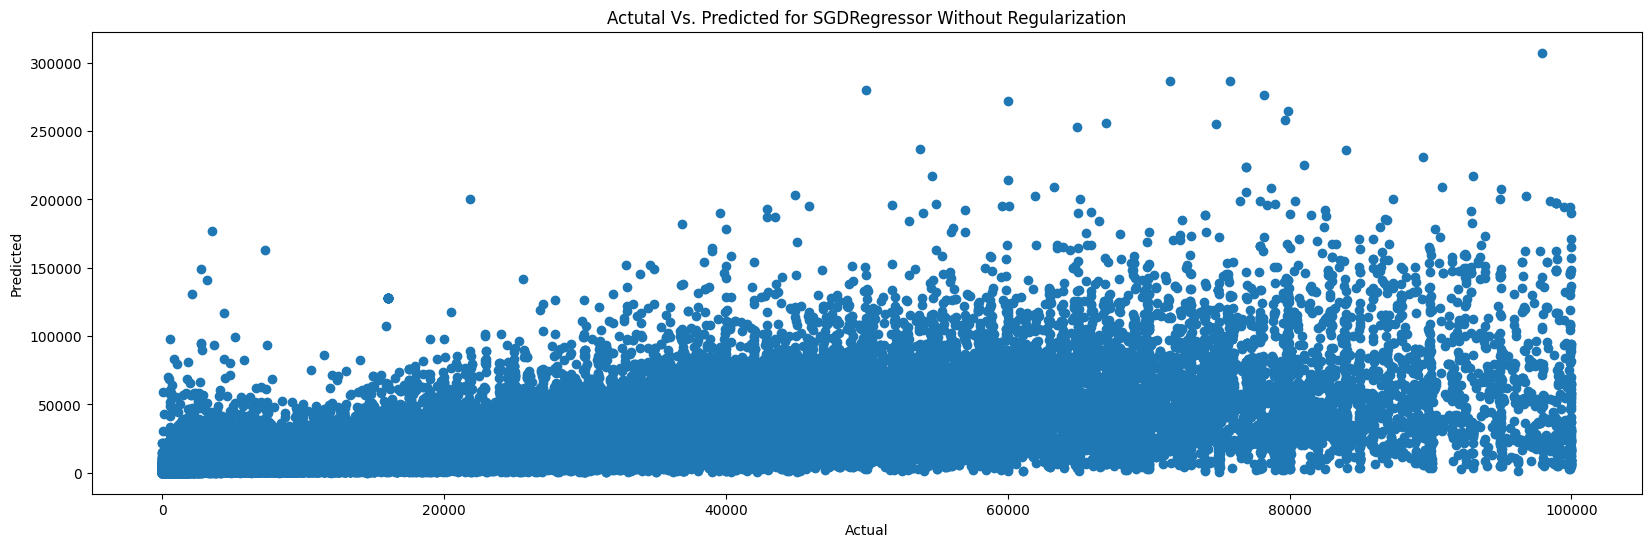

In [38]:
sgd_plain = SGDRegressor(penalty=None, random_state=1991).fit(Sparse_X_train, y_train)

sgd_plain_y = sgd_plain.predict(Sparse_X_test)

Score_Method(
    y_test,
    sgd_plain_y,
    "SGDRegressor Without Regularization",
)

## SGD Elastic Net with varying penalities

SGDRegressor(alpha=0.1, l1_ratio=0.1, penalty='elasticnet', random_state=1991)

R2         MSE    MAE
0  0.57  68,666,721  4,815

Actual Price  Predicted Price
0       1900.00      6628.635922
1      13851.04     10340.101051
2       8393.19      7416.604289
3      16494.00     12400.622878
4       6250.00      9126.151703

Columns  Coefficient
472      type_mercedes-benz_     0.092287
868  manufacture_year_2011.0     0.081091
869  manufacture_year_2012.0     0.117143
870  manufacture_year_2013.0     0.071565
872  manufacture_year_2014.0     0.101035
873  manufacture_year_2015.0     0.191282
874  manufacture_year_2016.0     0.005800
875        body_type_compact    -0.144391
878        body_type_offroad     0.039701
882            body_type_van     0.003336
889        transmission_auto     0.343304
890         transmission_man     0.259773
892           door_count_2.0     0.014903
894           door_count_4.0     0.177569
895           door_count_5.0     0.147936
902           seat_count_4.0     0.025237
903           seat_count_5.0     0.065123
908         fuel_type_diesel     0.142345
909       fuel_type_gasoline    -0.389331
910                  mileage    -0.521023
912             engine_power     0.397902

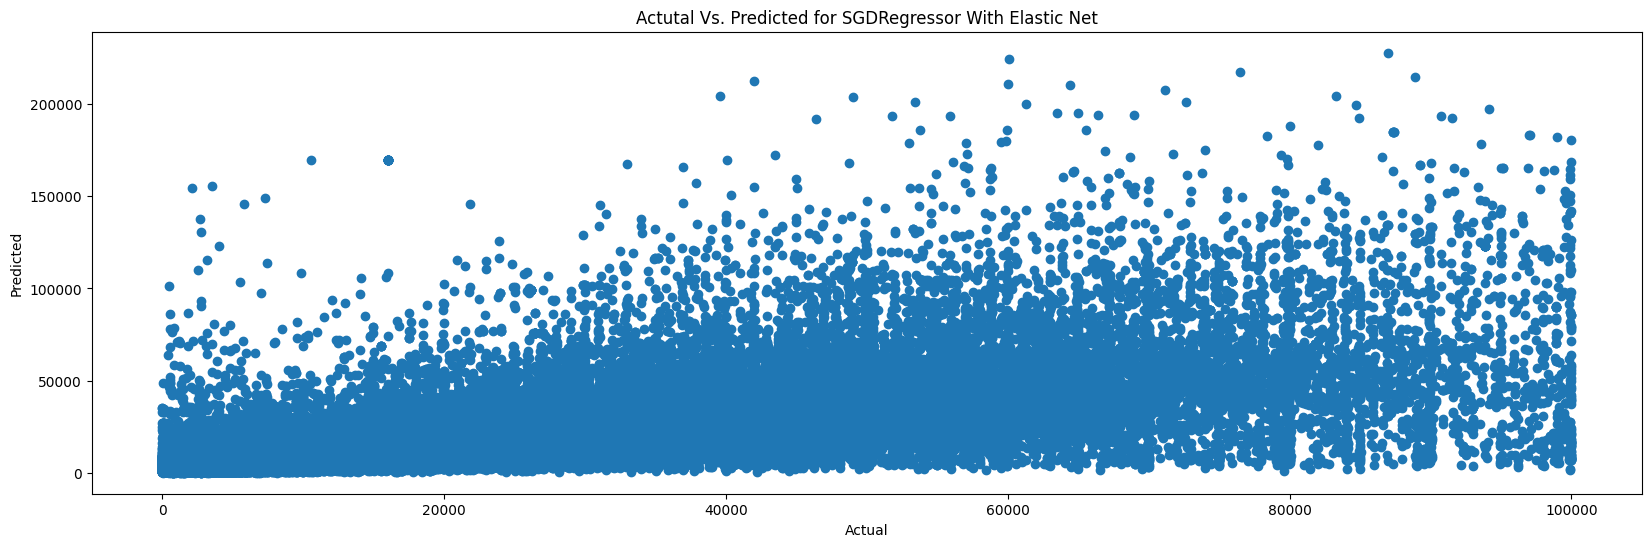

In [39]:
sgd_enet_grid = GridSearchCV(
    SGDRegressor(),
    param_grid={
        "random_state": [1991],
        "penalty": ["elasticnet"],
        "l1_ratio": np.arange(0.1, 1.1, 0.1),
        "alpha": np.arange(0.1, 1.1, 0.1),
    },
    n_jobs=14,
    cv=5,
)

sgd_enet_grid.fit(Sparse_X_train, y_train)

display(sgd_enet_grid.best_estimator_)

sgd_enet_grid_y = sgd_enet_grid.predict(Sparse_X_test)

Score_Method(y_test, sgd_enet_grid_y, "SGDRegressor With Elastic Net")
display(
    pd.DataFrame(
        {"Columns": ColumnNames, "Coefficient": sgd_enet_grid.best_estimator_.coef_}
    ).query("Coefficient!=0")
)

## SGD on Reduced Dataset

R2          MSE    MAE
0  0.35  102,749,389  5,325

Actual Price  Predicted Price
0       1900.00      7989.948107
1      13851.04     14338.329841
2       8393.19      7761.891433
3      16494.00     10993.055531
4       6250.00      6576.569064

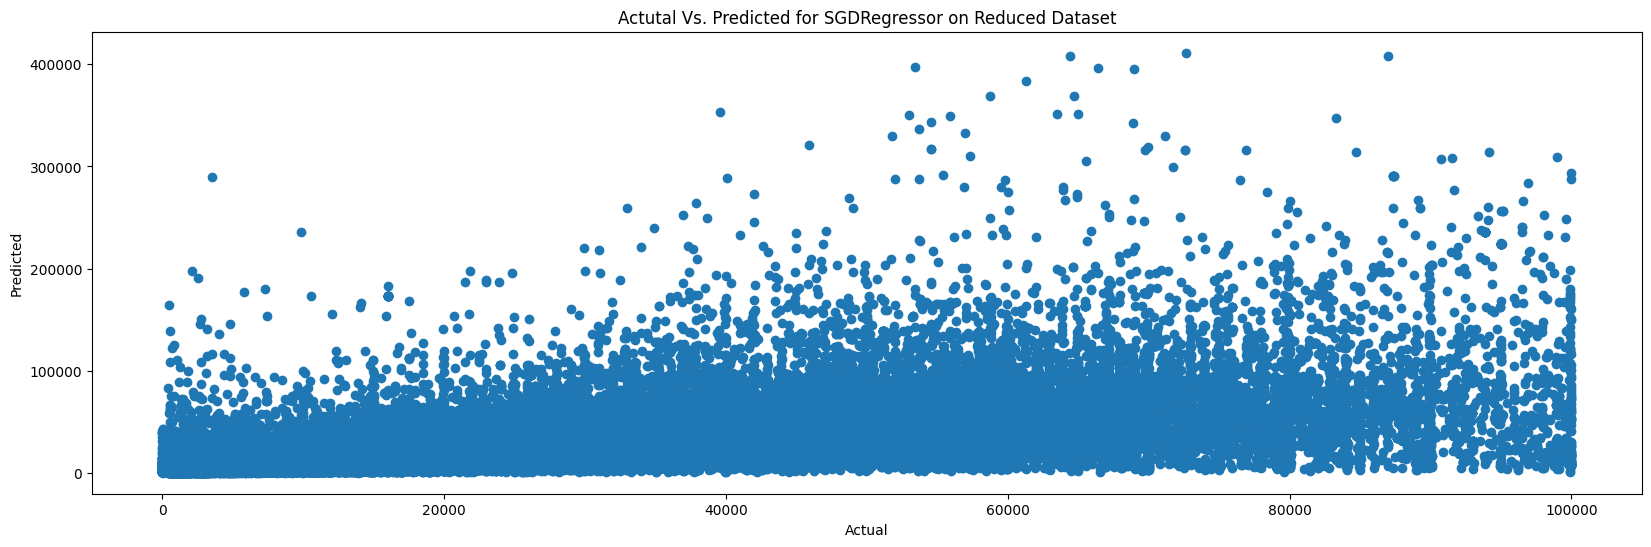

In [40]:
sgd_Reduced_Data = SGDRegressor(penalty=None, random_state=1991).fit(
    Six_D_Train, y_train
)

sgd_Reduced_Data_y = sgd_Reduced_Data.predict(Six_D_Test)

Score_Method(y_test, sgd_Reduced_Data_y, "SGDRegressor on Reduced Dataset")

# K Neighbors Regressor With Truncated SVD

## Tuning Distance Metrics & Weights

KNeighborsRegressor(n_neighbors=21, p=1.0, weights='distance')

R2         MSE    MAE
0  0.88  18,942,183  2,042

Actual Price  Predicted Price
0       1900.00      1900.000000
1      13851.04     12638.844366
2       8393.19      6763.697294
3      16494.00     16494.000000
4       6250.00      6531.830679

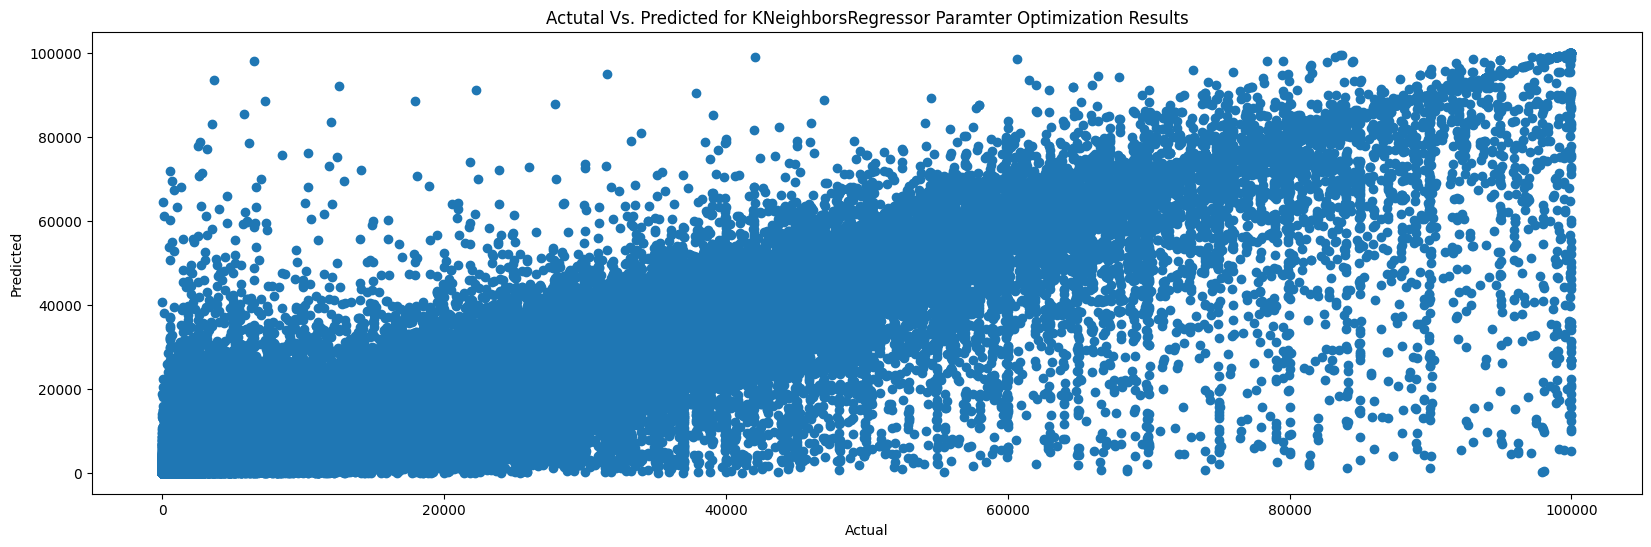

In [41]:
knr_grid_params = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        "p": [1.0, 2.0],
        "weights": ["uniform", "distance"],
        "n_neighbors": np.arange(20, 23, 1),
    },
    n_jobs=14,
    cv=5,
)

knr_grid_params.fit(Six_D_Train, y_train)

display(knr_grid_params.best_estimator_)

knr_grid_params_y = knr_grid_params.predict(Six_D_Test)

Score_Method(
    y_test,
    knr_grid_params_y,
    "KNeighborsRegressor Paramter Optimization Results",
)

## Tuning Number of Neighbour

KNeighborsRegressor(n_neighbors=21, p=1.0, weights='distance')

R2         MSE    MAE
0  0.88  18,942,183  2,042

Actual Price  Predicted Price
0       1900.00      1900.000000
1      13851.04     12638.844366
2       8393.19      6763.697294
3      16494.00     16494.000000
4       6250.00      6531.830679

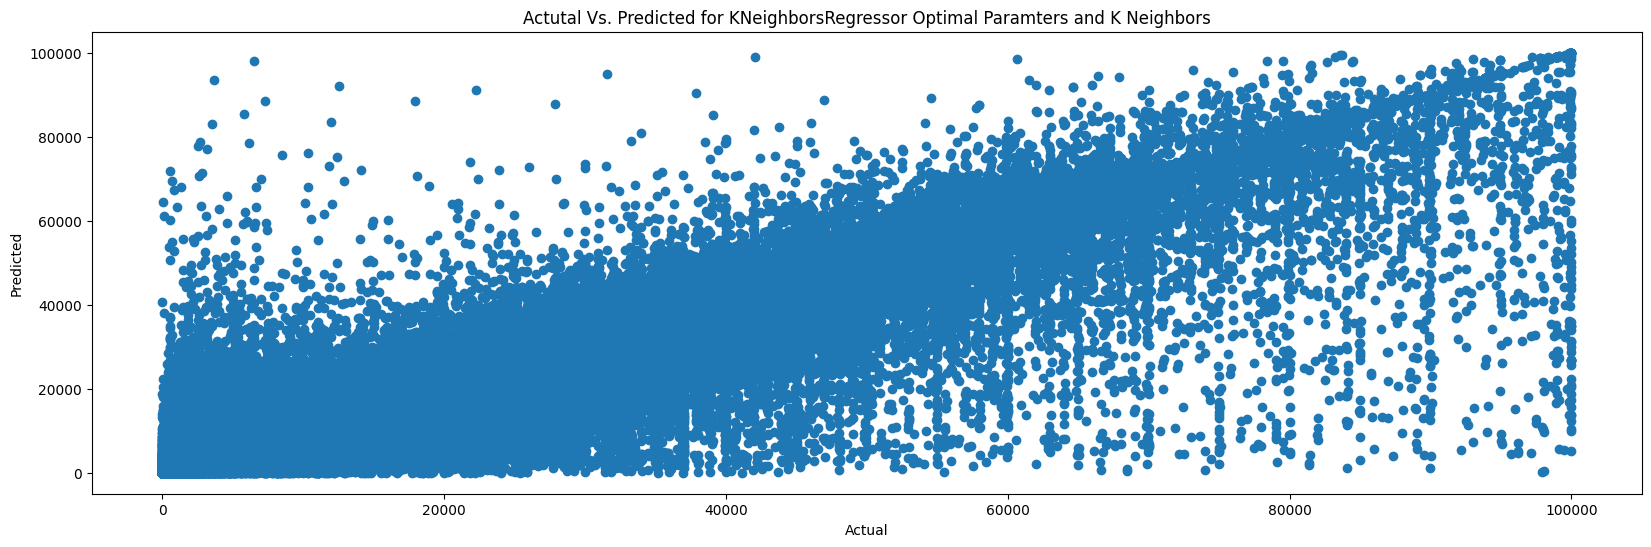

In [45]:
knr_grid_k = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        "p": [1.0],
        "weights": ["distance"],
        "n_neighbors": np.arange(18, 24, 1),
    },
    n_jobs=14,
    cv=5,
)

knr_grid_k.fit(Six_D_Train, y_train)

display(knr_grid_k.best_estimator_)

knr_grid_k_y = knr_grid_k.predict(Six_D_Test)

Score_Method(
    y_test,
    knr_grid_k_y,
    "KNeighborsRegressor Optimal Paramters and K Neighbors",
)

# AdaBoostRegressor With Trunctaed SVD

AdaBoostRegressor(random_state=1991)

R2         MSE    MAE
0  0.4  95,678,163  5,847

Actual Price  Predicted Price
0       1900.00      4541.605421
1      13851.04     21049.372415
2       8393.19     12684.460330
3      16494.00     13659.522952
4       6250.00     13659.522952

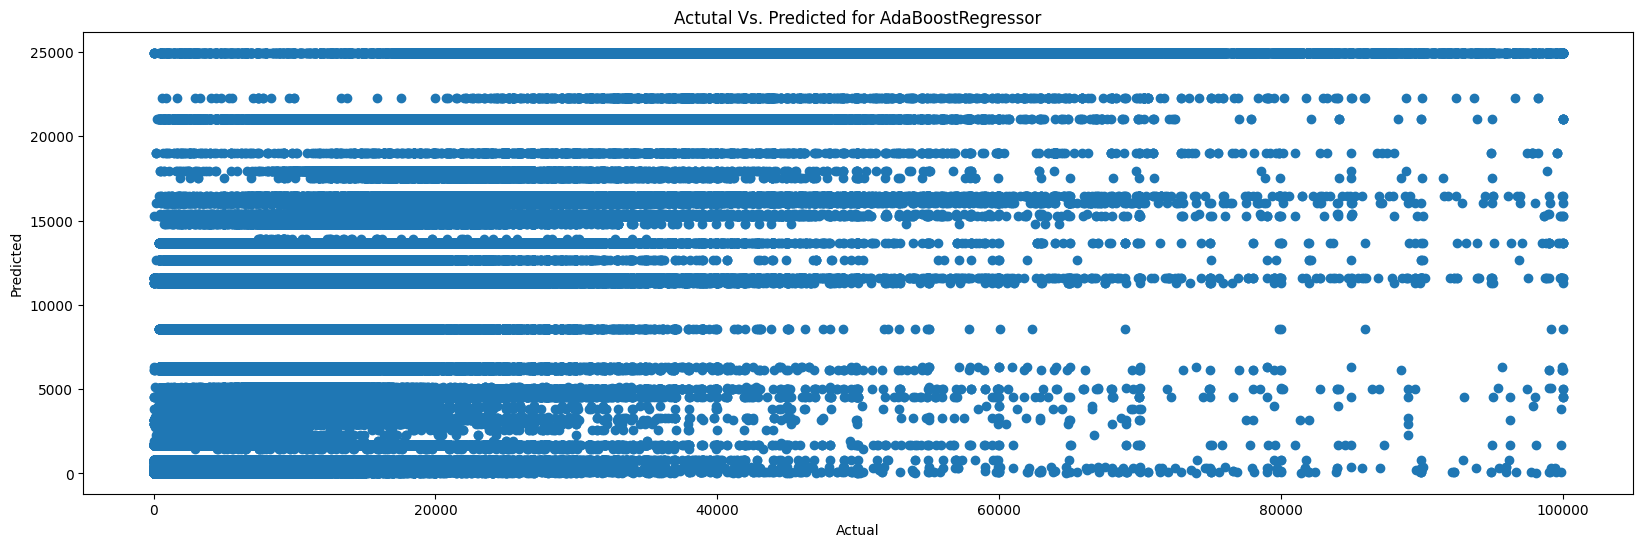

In [43]:
ada_grid = GridSearchCV(
    AdaBoostRegressor(),
    param_grid={
        "loss": ["linear"],
        "n_estimators": np.arange(50, 100, 10),
        "random_state": [1991],
    },
    n_jobs=14,
    cv=5,
)

ada_grid.fit(Six_D_Train, y_train)

display(ada_grid.best_estimator_)

ada_grid_y = ada_grid.predict(Six_D_Test)

Score_Method(y_test, ada_grid_y, "AdaBoostRegressor")

# XGBoost

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, n_jobs=None,
             num_parallel_tree=None, random_state=1991, ...)

R2         MSE    MAE
0  0.77  37,120,390  3,551

Actual Price  Predicted Price
0       1900.00      4220.370605
1      13851.04     13588.151367
2       8393.19      6242.325684
3      16494.00     16948.312500
4       6250.00      8671.645508

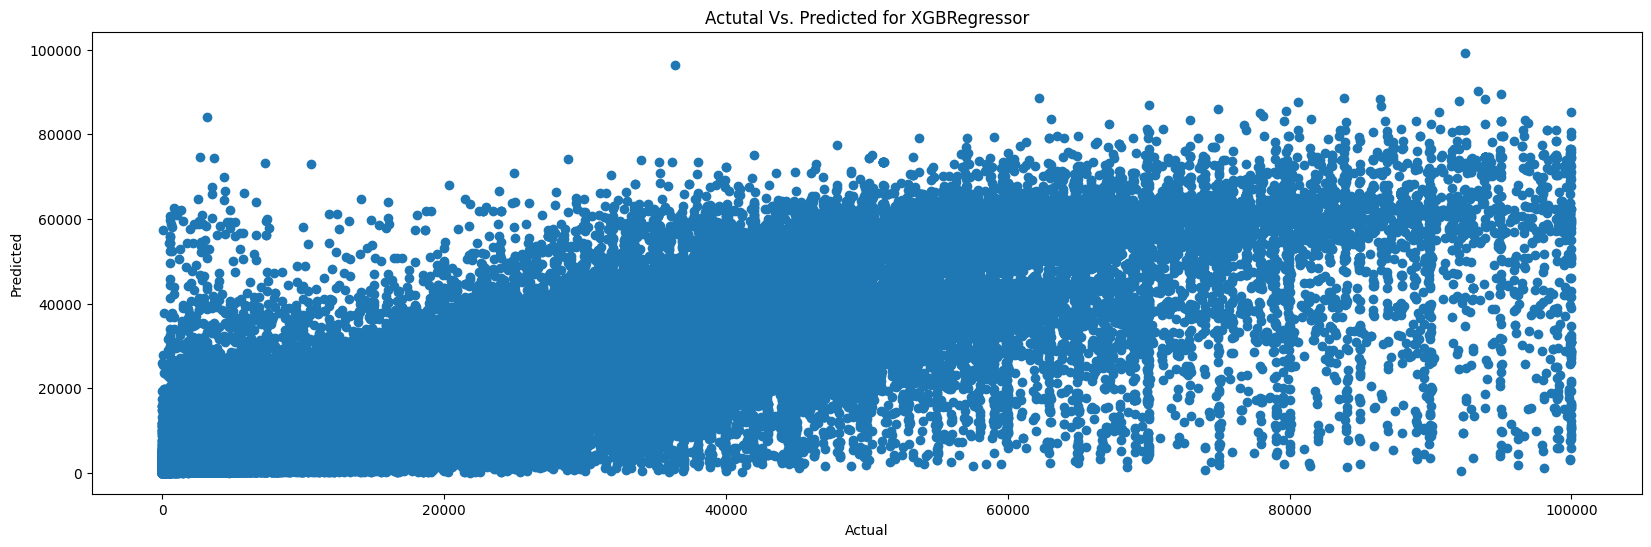

In [44]:
XGB_Grid = GridSearchCV(
    xg.XGBRegressor(),
    param_grid={
        "n_estimators": np.arange(10, 100, 10),
        "random_state": [1991],
    },
    n_jobs=14,
    cv=5,
)

XGB_Grid.fit(Six_D_Train, y_train)

display(XGB_Grid.best_estimator_)

XGB_Grid_y = XGB_Grid.predict(Six_D_Test)

Score_Method(y_test, XGB_Grid_y, "XGBRegressor")

# References

## Scientific

https://stats.stackexchange.com/questions/256172/why-is-dimensionality-reduction-always-done-before-clustering

https://community.databricks.com/t5/machine-learning/do-one-hot-encoding-ohe-before-or-after-split-data-to-train-and/td-p/17888#:~:text=%22If%20you%20perform%20the%20encoding,scores%20but%20poor%20in%20deployment).

https://datascience.stackexchange.com/questions/107714/encoding-before-vs-after-train-test-split

https://stats.stackexchange.com/questions/599508/do-we-one-hot-encode-create-dummy-variables-before-or-after-train-test-split

https://stats.stackexchange.com/questions/142216/zero-centering-the-testing-set-after-pca-on-the-training-set

https://stats.stackexchange.com/questions/55718/pca-and-the-train-test-split

https://stackoverflow.com/questions/55441022/how-to-aply-the-same-pca-to-train-and-test-set

https://stats.stackexchange.com/questions/278566/if-you-standardize-x-must-you-always-standardize-y

https://stats.stackexchange.com/questions/88245/scaling-data-why-not-standardize-response-variable-to-unit-variance-in-additio

## Coding

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

https://stackoverflow.com/questions/33603787/performing-pca-on-large-sparse-matrix-by-using-sklearn

https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix

https://stackoverflow.com/questions/20459536/convert-pandas-dataframe-to-sparse-numpy-matrix-directly

https://dantegates.github.io/2018/05/04/a-fast-one-hot-encoder-with-sklearn-and-pandas.html

https://pandas.pydata.org/docs/reference/api/pandas.SparseDtype.html

https://pandas.pydata.org/docs/reference/api/pandas.arrays.SparseArray.html

https://www.geeksforgeeks.org/xgboost-for-regression/

https://xgboost.readthedocs.io/en/stable/python/python_api.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

# PCA Vs Truncated SVD on KNeighborsRegressor(25, weights="distance")

PCA doesn't work on sparse Data.

2 Componenets
PCA yielded higher Accuracy at 2 components of 0.8178726424680244 vs 0.623305478122284 of Truncated SVD using seed 1991.

6 Componenets
PCA yielded Accuracy at 6 components of 0.8832974168967355 vs 0.8830232140933794 of Truncated SVD using seed 1991.

PCA Explained Variance ([1.79120925, 0.98414093, 0.389263  , 0.33659156, 0.30127252,
       0.27814113]) in 1m 26s

TSVD explained Variance ([1.39979887, 0.5979397 , 0.98411531, 0.36582389, 0.32243568,
       0.30120099]) in 22s

Adding more than 6 components yields very low improvement.

Isomap too slow.

# Clustiner

DBSCAN, HDBSCAN (Very slow)

# SGD Regrossor

0.7273975600580911 accuracy on raw data using seed 1991

0.6312 on Truncated SVD data with 6 components.